OLD
$$
\mathbf{H} = 
\begin{bmatrix}
	\begin{bmatrix}
	h_{11u} &  h_{11v} \\ \vdots \\ 
	h_{1iu} &  h_{1iv}
	\end{bmatrix}
	& 0
	\\
	0 &
	\begin{bmatrix}
	h_{s1u} &  h_{s1v} \\ \vdots \\ 
	h_{sku} &  h_{skv}
	\end{bmatrix}
\end{bmatrix}
$$

OLD
$$
\mathbf{x} = 
\begin{bmatrix}
	\begin{bmatrix}
	u_{1}\\  v_{1}
	\end{bmatrix}
	\\
	\vdots \\
	\begin{bmatrix}
	u_{s}\\ v_{s}
	\end{bmatrix}
\end{bmatrix}
$$



Maths for including a spatial correlations in the optical wave inversion algorithm
$$
F = F_0 + \mathbf{k}\mathbf{u}\cdot dt +\varepsilon
$$
$$
F -  F_0  = \Delta \phi =\mathbf{k}\mathbf{u}\cdot dt +\varepsilon
$$

$$
\mathbf{y} = \mathbf{H}\mathbf{x}+\varepsilon
$$

where

$$
\mathbf{y} = 
\begin{bmatrix}
	\begin{bmatrix}
	\Delta \phi_{11}\\ \vdots \\ \Delta \phi_{1i} 
	\end{bmatrix}
	\\
	\vdots \\
	\begin{bmatrix}
	\Delta \phi_{s1}\\ \vdots \\ \Delta \phi_{si}
	\end{bmatrix}
\end{bmatrix}
$$

is the observed phase lag, $\Delta \phi_{si}$, at each spatial location for each (coherent) wavenumber.

- $i$ - wavenumber index
- s - space index
- Size $[N\times 1]$. ($N$ is the total number of observations, number of spatial points times the number of coherent wavenumbers)

$$
\mathbf{H} = 
\begin{bmatrix}
	\begin{bmatrix}
	h_{11u}   \\ \vdots \\ 
	h_{1iu} 
	\end{bmatrix}
	& 0 &
    \begin{bmatrix}
	h_{11v}   \\ \vdots \\ 
	h_{1iv} 
	\end{bmatrix} 
    & 0
	\\
	0 &
	\begin{bmatrix}
	h_{s1u} \\ \vdots \\ 
	h_{sku} 
	\end{bmatrix}
    & 0 &
    \begin{bmatrix}
	h_{s1v} \\ \vdots \\ 
	h_{skv} 
	\end{bmatrix}
\end{bmatrix}
$$
is the "operator" matrix i.e. the linear operator to go from model to observations. For wave inversion  $h_{sku} = \mathbf{k}_k\ dt$   at location $s$.  

Size  $[2 \times S]$.



$$
\mathbf{x} = 
\begin{bmatrix}
	\begin{bmatrix}
	u_{1} \\ \vdots \\  u_{s}
	\end{bmatrix}
	\\
	\begin{bmatrix}
	v_{1} \\ \vdots \\ v_{s}
	\end{bmatrix}
\end{bmatrix}
$$

contains the velocity estimates.

The solution of $\mathbf{x}$ is (OI formula):

$$
\mathbf{x} = \mathbf{B_{md}}\mathbf{H}^T \left(\mathbf{H} \mathbf{B_{dd}}\mathbf{H}^T + \mathbf{R}\right)^{-1}\mathbf{y}
$$

and if you have the same model and data points B is just B
$$
\mathbf{x} = \mathbf{B}\mathbf{H}^T \left(\mathbf{H} \mathbf{B}\mathbf{H}^T + \mathbf{R}\right)^{-1}\mathbf{y}
$$

and the variance of the conditional distribution is:
$$
V[\mathbf{x}|\mathbf{y}] = \mathbf{B}\ - \mathbf{B}\mathbf{H}^T \left(\mathbf{H} \mathbf{B}\mathbf{H}^T + \mathbf{R}\right)^{-1}\mathbf{H}\mathbf{B}
$$
The model covariance matrix $\mathbf{B}$ is

$$
\mathbf{B} =
\begin{bmatrix}
\mathbf{C}_{uu} & \mathbf{C}_{uv} \\
\mathbf{C}_{vu} & \mathbf{C}_{vv} 
\end{bmatrix}
$$ 
Size $[2S\times 2S]$

The error covariance matrix $\mathbf{R}$ is
$$
\mathbf{R}\equiv V[\mathbf{\varepsilon}] = V[\varepsilon_s] 
\otimes
V[\varepsilon_k]
$$
- $V[\varepsilon_s]$ - is the spatial error covariance matrix. Size $[S\times S]$
- $V[\varepsilon_k]$ - is the wavenumber error covariance. Size $[K \times K]$.

Initially set
$$
\mathbf{R} = \sigma^2\mathbf{I}
$$
where size $\mathbf{I}= [N\times N]$.

In [1]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:42921")
client

<Client: 'tcp://127.0.0.1:42921' processes=4 threads=4, memory=15.62 GiB>

In [2]:
from scipy import sparse 
import numpy as np

import xarray as xr
import matplotlib.pyplot as plt

import sparse as dasksparse
from dask import array as da

from gptide import cov

In [134]:
# ds = xr.open_dataset('../../../DATA/49HGE_nativem_uv.nc')
# ds = xr.open_dataset('../../../DATA/49HGE_nativem_uv_128.nc')
# ds = xr.open_dataset('../../../DATA/49HGE_nativem_uv_bias.nc')
basedir = '../RPSLinkage/DATA/20240127'
# basedir = '../RPSLinkage/DATA/20240421'

ds = xr.open_dataset(f'{basedir}/49KGR_10m_uv_bias_512.nc')
ds = ds.isel(X=slice(5,15), Y=slice(5,15))
# ds = xr.open_dataset(f'{basedir}/49KGR_nativem_uv_128.nc')

ds

<xarray.Dataset>
Dimensions:        (Y: 10, X: 10, p: 2, nperseg: 64, granule_n: 512)
Coordinates:
  * Y              (Y) float64 7.572e+06 7.567e+06 ... 7.531e+06 7.526e+06
  * X              (X) float64 7.281e+05 7.332e+05 ... 7.691e+05 7.742e+05
  * p              (p) int64 0 1
  * nperseg        (nperseg) int64 0 1 2 3 4 5 6 7 8 ... 56 57 58 59 60 61 62 63
Dimensions without coordinates: granule_n
Data variables: (12/17)
    u              (Y, X) float64 ...
    v              (Y, X) float64 ...
    e              (Y, X) float64 ...
    bias           (Y, X) float64 ...
    dt             (Y, X) float64 ...
    n              (Y, X) float64 ...
    ...             ...
    residuals      (Y, X, nperseg, nperseg) float64 ...
    rhs            (Y, X, nperseg, nperseg) float64 ...
    granule_0_grd  (Y, X, granule_n, granule_n) float64 ...
    granule_1_grd  (Y, X, granule_n, granule_n) float64 ...
    kx             (nperseg, nperseg) float64 ...
    ky             (nperseg, nperseg) float64 ...
Attributes: (12/17)
    chunk:                     49KGR
    resolution_m:              10
    sensing_date_unix:         20240127T024311
    z1:                        49
    z2:                        K
    band_timing_nbar_band_02:  4.7
    ...                        ...
    band_timing_nbar_band_07:  6.5
    band_timing_nbar_band_12:  6.8
    export_filename:           /mnt/c/Users/00071913/OneDrive - The Universit...
    Lmin:                      10
    Lmax:                      200
    dx:                        10

In [304]:
# Spatial B kernel input parameters
η_uv = 0.1 # m/s
ℓ_uv = 10e3 # m

η_b = 0.01 # m/s
ℓ_b = 2.5e3 # m


# IID noise
noise = 0.005

# Coherence threshold
threshold = 0.8 # 0.8
Lmin = 50 # 10
Lmax = 300 #200
F0max = 20

bias = True

In [305]:
def phase_shift(F_bar, coh_bar, kx, ky, dt,
               coherence_threshold,
               Lmin, Lmax, F0max):
    # Compute the phase shift
    g=9.81
    depth=5000.
    K = np.abs(kx+1j*ky)
    L = 2*np.pi/K

    F0 = np.abs(dt)*np.sqrt(g*K*np.tanh(K*depth)) # Phase shift = dt*omega 
    F_F0_bar = np.abs(F_bar)-F0
    
    valid_points2 = F_bar<0 
    valid_points2 = valid_points2 & \
        (np.abs(F_F0_bar)*180/np.pi < F0max) 

    valid_points2 = valid_points2 \
        & (L>Lmin) & (L<Lmax)

    valid_points  = np.abs(coh_bar) > coherence_threshold
    valid_points2 = valid_points2 & valid_points

    return F_F0_bar, valid_points2

In [306]:

#Hlist = []
Hulist = []
Hvlist = []
Hblist = []
ylist = []
XYlist = []
for ii in range(ds.dims['X']):
    for jj in range(ds.dims['Y']):
        coh = ds['coh_bar'][jj,ii,...].values
        F_bar = ds['F_bar'][jj,ii,...].values
        dt = ds['dt'][jj,ii].values
        kx, ky = ds['kx'].values , ds['ky'].values

        dphi, idx = phase_shift(F_bar, coh, kx, ky, dt,
                               threshold,
                               Lmin, Lmax, F0max)

        #if np.sum(idx)>0:   
        # if bias:
        #     ones = np.ones_like(kx[idx])
        #     H = np.array([ones, kx[idx], ky[idx]]).T
        # else:
        #     H = np.array([kx[idx], ky[idx]]).T
            
        # Hlist.append(H)
        ones = np.ones_like(kx[idx])
        Hblist.append([ones])
        Hulist.append([kx[idx]])
        Hvlist.append([ky[idx]])

        ylist.append([dphi[idx]])
        #ylist.append([-dphi[idx]]) #???

        XYlist.append([ds['X'][ii].values, ds['Y'][jj].values])
        


/tmp/ipykernel_1985256/3039556388.py:8: RuntimeWarning: divide by zero encountered in divide
  L = 2*np.pi/K


In [307]:
Nobsold = np.hstack(ylist).shape[1]
Nobsold

11126

In [308]:
# Append a dummy point so that we can have square chunks (cholesky needs this)
chunksize=2000
nextra = chunksize - Nobsold%chunksize

ydummy = 1e-7 * np.ones((nextra,))

# if bias:
#     Hdummy = 1e-7 * np.ones((nextra,3)) # with bias
# else:
#     Hdummy = 1e-7 * np.ones((nextra,2))
# Hlist.append(Hdummy)
Hulist.append([ydummy])
Hvlist.append([ydummy])
Hblist.append([ydummy])

ylist.append([ydummy])
XYlist.append([XYlist[-1]])

In [324]:
y = np.hstack(ylist).T
X = np.vstack(XYlist)

Nobs = y.shape[0]
Nx = X.shape[0]

X.shape, y.shape, Nx

((101, 2), (12000, 1), 101)

In [310]:
#H = sparse.block_diag(Hlist).tocsc()
Hu = sparse.block_diag(Hulist).tocsc()
Hv = sparse.block_diag(Hvlist).tocsc()
Hb = sparse.block_diag(Hblist).tocsc()
if bias:
    H = sparse.hstack([Hu.T, Hv.T, Hb.T])
else:
    H = sparse.hstack([Hu.T, Hv.T])
H,y.shape, Nobs

(<12000x303 sparse matrix of type '<class 'numpy.float64'>'
 	with 35174 stored elements in Compressed Sparse Row format>,
 (12000, 1),
 12000)

In [311]:
Hs = dasksparse.COO.from_scipy_sparse(H)
Hs

Format,coo
Data Type,float64
Shape,"(12000, 303)"
nnz,35174
Density,0.009673817381738174
Read-only,True
Size,549.6K
Storage ratio,0.02


In [312]:
# Build "B" and "R" matrices
def matern32_2d(x, xpr, params):
    """
    2D kernel

    Inputs:
        x: matrices input points [N,3]
        xpr: matrices output points [M,3]
        params: tuple length 3
            eta: standard deviation
            lx: x length scale
            ly: y length scale

    """
    eta, lx, ly = params

    # Build the covariance matrix
    C  = cov.matern32(x[:,1,None], xpr[:,1,None].T, ly)
    C *= cov.matern32(x[:,0,None], xpr[:,0,None].T, lx)
    C *= eta**2

    return C


In [313]:
covfunc = matern32_2d
####

Buv = covfunc(X, X, (η_uv, ℓ_uv, ℓ_uv))
Bb = covfunc(X, X, (η_b, ℓ_b, ℓ_b))

# if bias:
#     Bm = sparse.eye(3) # with bias
# else:
#     Bm = sparse.eye(2)

# # B = sparse.kron(Bm, Bs).tocsc()
# B = sparse.kron(Bs, Bm).tocsc()

if bias:
    B = sparse.block_diag([Buv, Buv, Bb]).tocsc()
else:
    B = sparse.block_diag([Buv, Buv]).tocsc()

Bs = dasksparse.COO.from_scipy_sparse(B)
Bs

Format,coo
Data Type,float64
Shape,"(303, 303)"
nnz,30603
Density,0.3333333333333333
Read-only,True
Size,478.2K
Storage ratio,0.67


In [314]:
Hd = da.from_array(Hs, chunks=chunksize)
Hd

dask.array<array, shape=(12000, 303), dtype=float64, chunksize=(2000, 303), chunktype=sparse.COO>

In [315]:
Bd = da.from_array(Bs, chunks=chunksize)
Bd

dask.array<array, shape=(303, 303), dtype=float64, chunksize=(303, 303), chunktype=sparse.COO>

In [316]:
yd = da.from_array(y, chunks=chunksize)
yd

dask.array<array, shape=(12000, 1), dtype=float64, chunksize=(2000, 1), chunktype=numpy.ndarray>

In [317]:
# IID noise "R" matrix
N = y.shape[0]
R = noise*sparse.eye(N).tocsc()

Rs = dasksparse.COO.from_scipy_sparse(R)
Rd = da.from_array(Rs, chunks=chunksize)
Rd

dask.array<array, shape=(12000, 12000), dtype=float64, chunksize=(2000, 2000), chunktype=sparse.COO>

In [318]:
# Linear algebra time
BHt = Bd@Hd.T
HBHt_R = Hd@BHt + Rd
HBHt_R
# linalg routines require dense matrices...
HBHt_R_dense = da.map_blocks(dasksparse.COO.todense, HBHt_R)
HBHt_R_dense

dask.array<todense, shape=(12000, 12000), dtype=float64, chunksize=(2000, 2000), chunktype=numpy.ndarray>

In [319]:
# Cholesky solve (faster)
L = da.linalg.cholesky(HBHt_R_dense, lower=True)
v = da.linalg.solve_triangular(L, yd, lower=True)
HBHt_R_1_y = da.linalg.solve_triangular(L.T, v, lower=False)
x_ = BHt @ HBHt_R_1_y


In [320]:
%%time
x_ = x_.compute()

CPU times: user 20.2 ms, sys: 3.67 ms, total: 23.9 ms
Wall time: 13.8 s


In [321]:

# if bias:
#     outbias = x_[0::3]
#     u = x_[1::3]
#     v = x_[2::3]
# else:
#     u = x_[0::2]
#     v = x_[1::2]

if bias:
    outbias = x_[2*Nx:3*Nx]
    u = x_[0:Nx]
    v = x_[Nx:2*Nx]
else:
    u = x_[0:Nx]
    v = x_[Nx:2*Nx]


0.7552800980970532


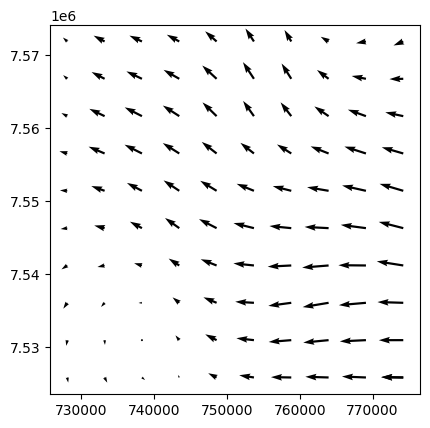

In [322]:
plt.figure()
ax=plt.subplot(111)
plt.quiver(X[:,0], X[:,1], u, v, scale_units='xy', scale=2e-4)
ax.set_aspect('equal')
speed = np.abs(u+1j*v)
print(speed.max())

-0.1002330137256279

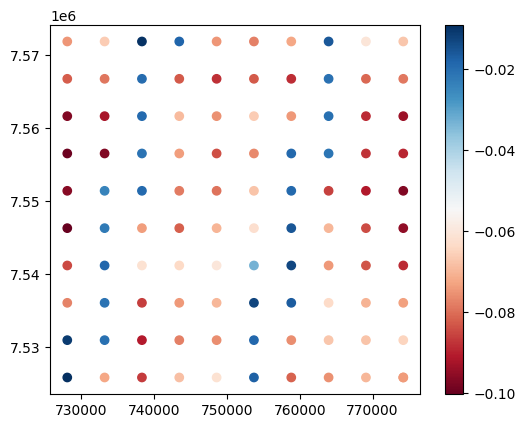

In [323]:
plt.figure()
ax=plt.subplot(111)
plt.scatter(X[:,0], X[:,1], c=outbias, cmap='RdBu')
ax.set_aspect('equal')
plt.colorbar()
outbias.min()

<xarray.DataArray ()>
array(1.11354149)

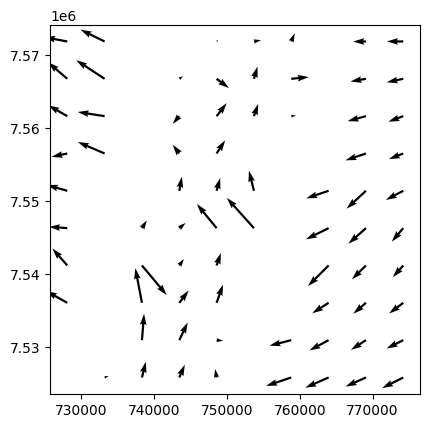

In [275]:
plt.figure()
# ax=plt.subplot(121)
# plt.quiver(X[:,0], X[:,1], u, v, scale_units='xy', scale=2e-4)
# ax.set_aspect('equal')
# speed = np.abs(u+1j*v)
# print(speed.max())

# ax2=plt.subplot(122, sharex=ax, sharey=ax)
ax2=plt.subplot(111)
plt.quiver(ds['X'], ds['Y'], ds['u'], ds['v'], scale_units='xy', scale=2e-4)
ax2.set_aspect('equal')
speed = np.abs(ds['u'] +1j * ds['v'])
speed.max()

In [276]:
from sfoda.utils.myproj import MyProj

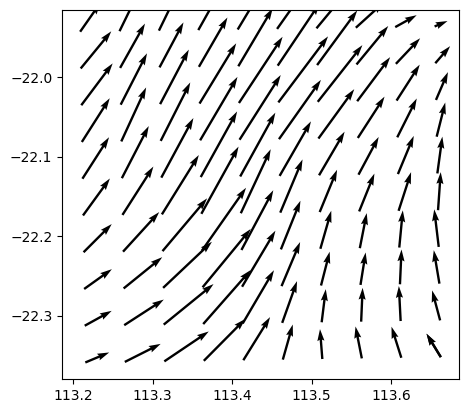

In [277]:
P = MyProj(None, utmzone=49, isnorth=False)
lon, lat = P.to_ll(X[:,0], X[:,1])
ax=plt.subplot(111)
plt.quiver(lon, lat, u, v, scale_units='xy', scale=10)
ax.set_aspect('equal')


Text(0.5, 1.0, 'IMOS Radar')

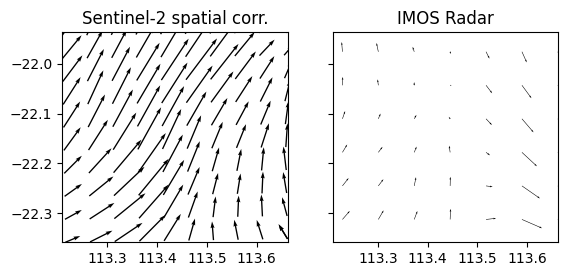

In [278]:
ds_r = xr.open_dataset('./IMOS_Ningaloo_HFRadar_20240127.nc')
ii=1
plt.figure()
ax=plt.subplot(121)
plt.quiver(lon, lat, u, v, scale_units='xy', scale=10)
ax.set_xlim(lon.min(), lon.max())
ax.set_ylim(lat.min(), lat.max())
ax.set_aspect('equal')


ax2=plt.subplot(122)
x,y = ds_r['LONGITUDE'],ds_r['LATITUDE']
ax2.quiver(x,y, ds_r.UCUR[ii,...], ds_r.VCUR[ii,...], scale_units='xy', scale=10)
ax2.set_yticklabels([])
ax2.set_xlim(lon.min(), lon.max())
ax2.set_ylim(lat.min(), lat.max())
ax2.set_aspect('equal')
ax.set_title('Sentinel-2 spatial corr.')
ax2.set_title('IMOS Radar')

Text(0.5, 1.0, 'IMOS Radar')

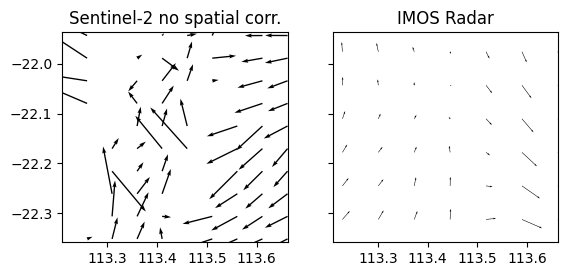

In [279]:
lon2, lat2 = P.to_ll(ds['X'], ds['Y'])
ax=plt.subplot(121)
plt.quiver(lon2, lat2, ds['u'], ds['v'], scale_units='xy', scale=10)
ax.set_xlim(lon.min(), lon.max())
ax.set_ylim(lat.min(), lat.max())
ax.set_aspect('equal')


ax2=plt.subplot(122)
x,y = ds_r['LONGITUDE'],ds_r['LATITUDE']
ax2.quiver(x,y, ds_r.UCUR[ii,...], ds_r.VCUR[ii,...], scale_units='xy', scale=10)
ax2.set_yticklabels([])
ax2.set_xlim(lon.min(), lon.max())
ax2.set_ylim(lat.min(), lat.max())
ax2.set_aspect('equal')
ax.set_title('Sentinel-2 no spatial corr.')
ax2.set_title('IMOS Radar')

/home/jupyter-mrayson/.local/lib/python3.10/site-packages/xarray/coding/times.py:254: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(


Text(0.5, 1.0, 'SWOT')

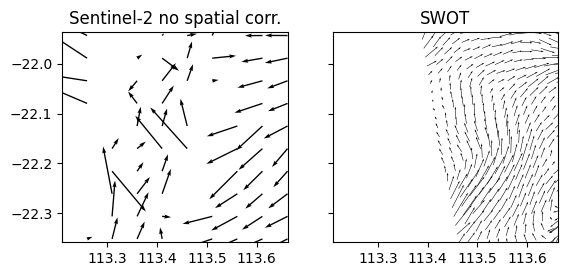

In [280]:
ds_s = xr.open_dataset('./SWOT_L3_v1_0_062_Ningaloo.nc')

plt.figure()
ax=plt.subplot(121)
plt.quiver(lon2, lat2, ds['u'], ds['v'], scale_units='xy', scale=10)
ax.set_xlim(lon.min(), lon.max())
ax.set_ylim(lat.min(), lat.max())
ax.set_aspect('equal')
# ax.quiver(x,y, ds_s.ugosa[ii,...], ds_s.vgosa[ii,...],
#            scale_units='xy', scale=10)

ii=7
ax2=plt.subplot(122)
x,y = ds_s['longitude'],ds_s['latitude']
ax2.quiver(x,y, ds_s.ugosa[ii,...], ds_s.vgosa[ii,...], scale_units='xy', scale=10)
ax2.set_yticklabels([])
ax2.set_xlim(lon.min(), lon.max())
ax2.set_ylim(lat.min(), lat.max())
ax2.set_aspect('equal')
ax.set_title('Sentinel-2 no spatial corr.')
ax2.set_title('SWOT')

Text(0.5, 1.0, 'SWOT')

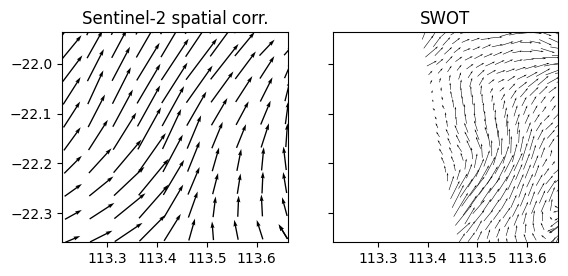

In [281]:
plt.figure()
ax=plt.subplot(121)
plt.quiver(lon, lat, u, v, scale_units='xy', scale=10)
ax.set_xlim(lon.min(), lon.max())
ax.set_ylim(lat.min(), lat.max())
ax.set_aspect('equal')
# ax.quiver(x,y, ds_s.ugosa[ii,...], ds_s.vgosa[ii,...],
#            scale_units='xy', scale=10)

ii=7
ax2=plt.subplot(122)
x,y = ds_s['longitude'],ds_s['latitude']
ax2.quiver(x,y, ds_s.ugosa[ii,...], ds_s.vgosa[ii,...], scale_units='xy', scale=10)
ax2.set_yticklabels([])
ax2.set_xlim(lon.min(), lon.max())
ax2.set_ylim(lat.min(), lat.max())
ax2.set_aspect('equal')
ax.set_title('Sentinel-2 spatial corr.')
ax2.set_title('SWOT')

In [282]:
import s3fs
import cmocean
sstfile = 'imos-data/IMOS/SRS/SST/ghrsst/L3C-1d/ngt/snpp/2024/20240127152000-ABOM-L3C_GHRSST-SSTskin-VIIRS_NPP-1d_night.nc'
fs = s3fs.S3FileSystem(anon=True)

fileobj = fs.open(sstfile)
sst = xr.open_dataset(fileobj)
x1,x2=lon.min(), lon.max()
y1,y2=lat.min(), lat.max()
mysst = sst.sel(lon=slice(x1,x2), lat=slice(y2,y1))
dx, dy = np.gradient(mysst['sea_surface_temperature'].squeeze())
xs,ys = mysst.lon, mysst.lat

Text(0.5, 1.0, 'SWOT')

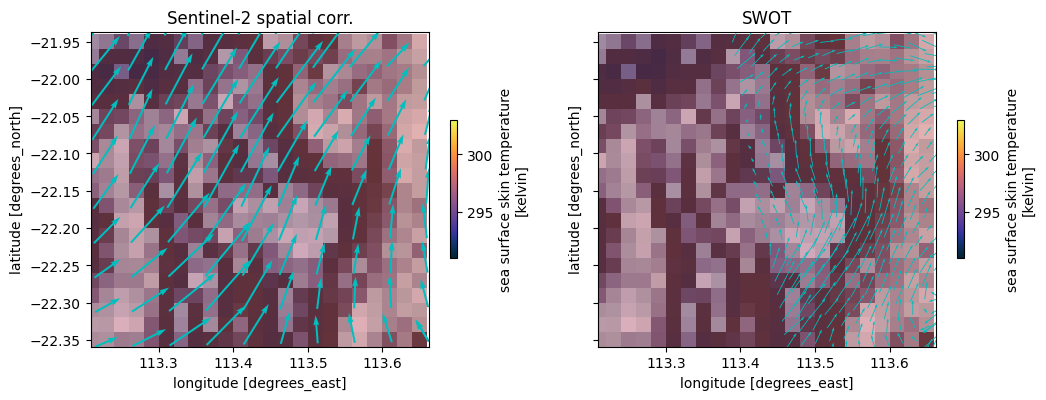

In [283]:
plt.figure(figsize=(12,6))
ax=plt.subplot(121)
mysst['sea_surface_temperature'].plot(ax=ax, cmap='cmo.thermal',vmin=18+273, vmax=30+273,cbar_kwargs={"shrink": 0.3,})
ax.pcolormesh(xs,ys,np.abs(dx+1j*dy), vmin=0, vmax=0.2, cmap='bone_r', alpha=0.5)
plt.quiver(lon, lat, u, v, scale_units='xy', scale=10, color='c')
ax.set_xlim(lon.min(), lon.max())
ax.set_ylim(lat.min(), lat.max())
ax.set_aspect('equal')
# ax.quiver(x,y, ds_s.ugosa[ii,...], ds_s.vgosa[ii,...],
#            scale_units='xy', scale=10)

ii=7
ax2=plt.subplot(122)


x,y = ds_s['longitude'],ds_s['latitude']
mysst['sea_surface_temperature'].plot(ax=ax2, cmap='cmo.thermal',vmin=18+273, vmax=30+273,cbar_kwargs={"shrink": 0.3,})
ax2.pcolormesh(xs,ys,np.abs(dx+1j*dy), vmin=0, vmax=0.2, cmap='bone_r', alpha=0.5)
ax2.quiver(x,y, ds_s.ugosa[ii,...], ds_s.vgosa[ii,...], scale_units='xy', scale=10, color='c')
ax2.set_yticklabels([])
ax2.set_xlim(lon.min(), lon.max())
ax2.set_ylim(lat.min(), lat.max())
ax2.set_aspect('equal')
ax.set_title('Sentinel-2 spatial corr.')
ax2.set_title('SWOT')

